<a href="https://colab.research.google.com/github/seonmia/MRC_KoBigBird_KoELECTRA/blob/main/KobigBird_with_validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Colab Mount & Import Libraries

In [ ]:
pwd

'/content'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_file = "data/train.json"
add_train_file = 'data/017.뉴스 기사 기계독해 데이터/01.데이터/1.Training/라벨링데이터/TL_span_extraction.json'
add_train_rev_file = "data/data_extraction_answer_len20.json"
test_file = "data/test.json"
blank_file = "data/blank.csv"

In [ ]:
%cd /content/drive/MyDrive/GoormProject/GoormProject2

/content/drive/.shortcut-targets-by-id/1ovgSHdL_LDsDV-KWBQ2NNEs2v8Mpi0fm/GoormProject/GoormProject2


In [ ]:
!pip install transformers
!pip install sentencepiece
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 14.5 MB/s 
     |████████████████████████████████| 101 kB 13.1 MB/s 
     |████████████████████████████████| 596 kB 82.8 MB/s 
     |████████████████████████████████| 6.6 MB 66.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.2 MB 14.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 14.4 MB/s 
     |████████████████████████████████| 156 kB 90.7 MB/s 
     |████████████████████████████████| 181 kB 79.1 MB/s 
     |████████████████████████████████| 63 kB 2.1 MB/s 
  Created wheel for pathtools: fil

In [ ]:
import os
import random
import math
import csv
import json
from tqdm.notebook import tqdm
from easydict import EasyDict as edict
from statistics import mean
from typing import List, Tuple, Dict, Any

import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

import wandb

import torch
from torch.utils.data import DataLoader
from torch.nn.utils import clip_grad_norm_
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F


from transformers import (
    BertTokenizer,
    BertForQuestionAnswering,
    AutoConfig,
    AdamW,
    AlbertTokenizer,
    AlbertForSequenceClassification,
    ElectraModel,
    ElectraTokenizer,
    ElectraForQuestionAnswering, 
    AutoModelForQuestionAnswering, 
    AutoTokenizer
)

# Config

In [ ]:
args = edict({'w_project': 'KoBigBird',
              'w_entity': 'ushape', # WandB ID
              'learning_rate': 2e-4,
              'batch_size': {'train': 128,
                             'eval': 4,
                             'test': 128},
              'accumulate': 32,
              'epochs': 10,
              'seed': 42,
              'model_name': 'monologg/kobigbird-bert-base',
              'max_length': 2048})
args['NAME'] = ''f'kobigbird_v2_ep{args.epochs}_max{args.max_length}_lr{args.learning_rate}_{random.randrange(0, 1024)}'
print(args.NAME)

kobigbird_v2_ep10_max2048_lr0.0002_216


# Setting Model

In [ ]:
 def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = True  # type: ignore

seed_everything(args.seed)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(args.model_name)


In [ ]:
# model = AutoModelForQuestionAnswering.from_pretrained(args.model_name)
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = AutoModelForQuestionAnswering.from_pretrained(args.model_name)
# model.to(device)

Some weights of the model checkpoint at monologg/kobigbird-bert-base were not used when initializing BigBirdForQuestionAnswering: ['cls.seq_relationship.bias', 'bert.pooler.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'bert.pooler.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BigBirdForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BigBirdForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of 

In [ ]:
model.cuda();

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=args.learning_rate)

# Preprocessing

## KoMRC

In [ ]:
from typing import List, Tuple, Dict, Any
import json
import random

class KoMRC:
    def __init__(self, data, indices: List[Tuple[int, int, int]]):
        self._data = data
        self._indices = indices

    # Json을 불러오는 메소드
    @classmethod
    def load(cls, file_path: str):
        with open(file_path, 'r', encoding='utf-8') as fd:
            data = json.load(fd)

        indices = []
        for d_id, document in enumerate(data['data']):
            for p_id, paragraph in enumerate(document['paragraphs']):
                for q_id, _ in enumerate(paragraph['qas']):
                    indices.append((d_id, p_id, q_id))
        
        return cls(data, indices)

##################################################################
    # 데이터 셋을 잘라내는 메소드
    @classmethod
    def split(cls, dataset, train_raio: float=.8,test_ratio: float=.5, seed=42):
        indices = list(dataset._indices)
        random.seed(seed)
        random.shuffle(indices)
        train_indices = indices[:int(len(indices) * train_raio)]
        split_indices = indices[int(len(indices) * train_raio):]
        eval_indices = split_indices[:int(len(split_indices) * test_ratio)]
        test_indices = split_indices[int(len(split_indices) * test_ratio):]

        return cls(dataset._data, train_indices), cls(dataset._data, eval_indices), cls(dataset._data, test_indices)
################################################################################

    def __getitem__(self, index: int) -> Dict[str, Any]:
        d_id, p_id, q_id = self._indices[index]
        paragraph = self._data['data'][d_id]['paragraphs'][p_id]

        context = paragraph['context']
        qa = paragraph['qas'][q_id]

        guid = qa['guid']
        question = qa['question']
        answers = qa['answers']

        return {
            'guid': guid,
            'context': context,
            'question': question,
            'answers': answers
        }

    def __len__(self) -> int:
        return len(self._indices)

In [ ]:
from pprint import pprint
dataset = KoMRC.load(train_file)
pprint(dataset[0])

{'answers': [{'answer_start': 478, 'text': '한 달가량'},
             {'answer_start': 478, 'text': '한 달'}],
 'context': '올여름 장마가 17일 제주도에서 시작됐다. 서울 등 중부지방은 예년보다 사나흘 정도 늦은 이달 말께 장마가 시작될 '
            '전망이다.17일 기상청에 따르면 제주도 남쪽 먼바다에 있는 장마전선의 영향으로 이날 제주도 산간 및 내륙지역에 '
            '호우주의보가 내려지면서 곳곳에 100㎜에 육박하는 많은 비가 내렸다. 제주의 장마는 평년보다 2~3일, 지난해보다는 '
            '하루 일찍 시작됐다. 장마는 고온다습한 북태평양 기단과 한랭 습윤한 오호츠크해 기단이 만나 형성되는 장마전선에서 '
            '내리는 비를 뜻한다.장마전선은 18일 제주도 먼 남쪽 해상으로 내려갔다가 20일께 다시 북상해 전남 남해안까지 영향을 '
            '줄 것으로 보인다. 이에 따라 20~21일 남부지방에도 예년보다 사흘 정도 장마가 일찍 찾아올 전망이다. 그러나 '
            '장마전선을 밀어올리는 북태평양 고기압 세력이 약해 서울 등 중부지방은 평년보다 사나흘가량 늦은 이달 말부터 장마가 '
            '시작될 것이라는 게 기상청의 설명이다. 장마전선은 이후 한 달가량 한반도 중남부를 오르내리며 곳곳에 비를 뿌릴 '
            '전망이다. 최근 30년간 평균치에 따르면 중부지방의 장마 시작일은 6월24~25일이었으며 장마기간은 32일, '
            '강수일수는 17.2일이었다.기상청은 올해 장마기간의 평균 강수량이 350~400㎜로 평년과 비슷하거나 적을 것으로 '
            '내다봤다. 브라질 월드컵 한국과 러시아의 경기가 열리는 18일 오전 서울은 대체로 구름이 많이 끼지만 비는 오지 않을 '
            '것으로 예상돼 거리 응원에는 지

## TokenizedKoMRC

In [ ]:
from typing import Generator
class TokenizedKoMRC(KoMRC):
    def __init__(self, data, indices: List[Tuple[int, int, int]]) -> None:
        super().__init__(data, indices)
        self._tokenizer  = tokenizer
    
    def _tokenize_with_position(self, sentence: str) -> List[Tuple[str, Tuple[int, int]]]:
        position = 0
        tokens = []
        sentence_tokens = []

        for word in sentence.split(): 
            if '[UNK]' in tokenizer.tokenize(word):
                sentence_tokens.append(word)
            else:
                sentence_tokens += tokenizer.tokenize(word)
        
        # 토크나이저 변경에 따른 ## 대응 및 포지션 조정
        for morph in sentence_tokens:
            if len(morph) > 2:
                if morph[:2] == '##':
                    morph = morph[2:]

            position = sentence.find(morph, position)
            tokens.append((morph, (position, position + len(morph)))) 
            position += len(morph) 
        
        return tokens
    
    def __getitem__(self, index: int) -> Dict[str, Any]:
        sample = super().__getitem__(index)

        context, position = zip(*self._tokenize_with_position(sample['context']))
        context, position = list(context), list(position)

        question = self._tokenizer.tokenize(sample['question'])

        if sample['answers'] is not None:
            answers = []

            # 여러 답 중 짧은 답만 학습
            local_shortest_answer_len = 200; local_shortest_answer_idx = 0
            for i, answer in enumerate(sample['answers']):
                if len(answer['text'])<local_shortest_answer_len:
                  local_shortest_answer_len = len(answer['text'])
                  local_shortest_answer_idx=i
            answer=sample['answers'][local_shortest_answer_idx]
            for start, (position_start, position_end) in enumerate(position):
                if position_start <= answer['answer_start'] < position_end:
                    break

            target = ''.join(answer['text'].split(' '))
            source = ''
            for end, morph in enumerate(context[start:], start):
                source += morph
                if target in source:
                    break

            answers.append({'start': start, 'end': end})
            answer_text = sample['answers'][0]['text']

        else:
            answers = None
            answer_text = None
        
        return {
            'guid': sample['guid'],
            'context_original': sample['context'],
            'context_position': position,
            'question_original': sample['question'],
            'context': context,
            'question': question,
            'answers': answers,
            'answers_text': answer_text
        }

In [ ]:
dataset = TokenizedKoMRC.load(train_file)
train_dataset, dev_dataset = TokenizedKoMRC.split(dataset)
print("Number of Samples:", len(dataset))
print("Number of Train Samples:", len(train_dataset))
print("Number of Dev Samples:", len(dev_dataset))
print(dev_dataset[0])

Number of Samples: 12037
Number of Train Samples: 10834
Number of Dev Samples: 1203
{'guid': '844e22ab28924c1697d5ac28801b34c1', 'context_original': '지난해 주요 연극상을 나눠 가졌던 세 편의 작품이 올봄에 나란히 앙코르 무대를 갖는다. 대한민국연극대상 연기·무대예술상, 동아연극상 작품·희곡·연기상 등을 수상한 ‘알리바이 연대기’(17~20일 대학로 아르코예술극장 대극장, 25일~5월11일 서계동 국립극단 백성희장민호극장), 연극대상에서 대상과 희곡상을 받은 ‘여기가 집이다’(18일~5월22일 대학로 연우소극장), 연극대상 작품·연출상과 김상열연극상 수상작인 ‘황금용’(5월9~18일 서강대 메리홀 대극장)이다. 초연 당시 짧은 상연 기간과 낮은 인지도 등으로 공연을 놓친 연극팬에겐 평단으로부터 작품성을 인정받은 수작을 관람할 수 있는 기회다. ‘알리바이 연대기’는 희곡을 쓰고 연출한 김재엽의 가족사에 근거한 다큐멘터리 드라마다. 1930년에 태어난 한 개인의 사적인 연대기를 바탕으로 그 사이를 파고드는 역사적 순간들을 정밀하게 조명한다. 연출가는 “공적인 권력이 사적인 권리를 지켜주기보다 억압하기 일쑤였던 한국 현대사 속에서 개인은 언제나 무죄를 입증하며 하루하루 자신을 지켜내야 하는 ‘알리바이의 연대기’ 속에서 살아왔다”고 말한다.한국연극평론가협회는 이 작품을 ‘2013년 올해의 연극 베스트3’로 선정하며 “촘촘하고 세세하게 삶에 천착해 개인과 역사에 대한 이분법적 관점을 극복한다. 정치극에 대한 새로운 가능성을 보여줬다”고 평했다. 이 작품으로 연기상을 휩쓴 남명렬을 비롯해 지춘성 정원조 등 초연 배우들이 그대로 출연한다.‘여기가 집이다’는 허름하고 볼품 없는 ‘20년 전통’의 고시원에 모여 사는 사람들의 절망과 희망을 그린 작품. ‘차력사와 아코디언’ ‘택배 왔어요’를 만든 극단 이와삼의 장우재 대표가 직접 대본을 쓰고 연출했다. 나름의 

## Indexer

### current

In [ ]:
class Indexer:
    def __init__(self, vocabs: List[str], max_length: int=args.max_length):
        self.max_length = args.max_length
        self.vocabs = vocabs

    @property
    def vocab_size(self):
        return len(self.vocabs)
    @property
    def pad_id(self):
        return tokenizer.vocab['[PAD]']
    @property
    def unk_id(self):
        return tokenizer.vocab['[UNK]']
    @property
    def cls_id(self):
        return tokenizer.vocab['[CLS]']
    @property
    def sep_id(self):
        return tokenizer.vocab['[SEP]']


    def sample2ids(self, sample: Dict[str, Any],) -> Dict[str, Any]:
        context = [tokenizer.convert_tokens_to_ids(token) for token in sample['context']]
        question = [tokenizer.convert_tokens_to_ids(token) for token in sample['question']]

        context = context[:self.max_length-len(question)-3]             # Truncate context
        
        input_ids = [self.cls_id] + question + [self.sep_id] + context + [self.sep_id]
        token_type_ids = [0] * (len(question) + 1) + [1] * (len(context) + 2)

        if sample['answers'] is not None:
            answer = sample['answers'][0]
            start = min(len(question) + 2 + answer['start'], self.max_length - 1)
            end = min(len(question) + 2 + answer['end'], self.max_length - 1)
        else:
            start = None
            end = None

        return {
            'guid': sample['guid'],
            'context': sample['context_original'],
            'question': sample['question_original'],
            'position': sample['context_position'],
            'input_ids': input_ids,
            'token_type_ids': token_type_ids,
            'start': start,
            'end': end,
            'answers_text': sample['answers_text']
        }

In [ ]:
indexer = Indexer(list(tokenizer.vocab.keys()))
print(indexer.sample2ids(dev_dataset[0]))

{'guid': '844e22ab28924c1697d5ac28801b34c1', 'context': '지난해 주요 연극상을 나눠 가졌던 세 편의 작품이 올봄에 나란히 앙코르 무대를 갖는다. 대한민국연극대상 연기·무대예술상, 동아연극상 작품·희곡·연기상 등을 수상한 ‘알리바이 연대기’(17~20일 대학로 아르코예술극장 대극장, 25일~5월11일 서계동 국립극단 백성희장민호극장), 연극대상에서 대상과 희곡상을 받은 ‘여기가 집이다’(18일~5월22일 대학로 연우소극장), 연극대상 작품·연출상과 김상열연극상 수상작인 ‘황금용’(5월9~18일 서강대 메리홀 대극장)이다. 초연 당시 짧은 상연 기간과 낮은 인지도 등으로 공연을 놓친 연극팬에겐 평단으로부터 작품성을 인정받은 수작을 관람할 수 있는 기회다. ‘알리바이 연대기’는 희곡을 쓰고 연출한 김재엽의 가족사에 근거한 다큐멘터리 드라마다. 1930년에 태어난 한 개인의 사적인 연대기를 바탕으로 그 사이를 파고드는 역사적 순간들을 정밀하게 조명한다. 연출가는 “공적인 권력이 사적인 권리를 지켜주기보다 억압하기 일쑤였던 한국 현대사 속에서 개인은 언제나 무죄를 입증하며 하루하루 자신을 지켜내야 하는 ‘알리바이의 연대기’ 속에서 살아왔다”고 말한다.한국연극평론가협회는 이 작품을 ‘2013년 올해의 연극 베스트3’로 선정하며 “촘촘하고 세세하게 삶에 천착해 개인과 역사에 대한 이분법적 관점을 극복한다. 정치극에 대한 새로운 가능성을 보여줬다”고 평했다. 이 작품으로 연기상을 휩쓴 남명렬을 비롯해 지춘성 정원조 등 초연 배우들이 그대로 출연한다.‘여기가 집이다’는 허름하고 볼품 없는 ‘20년 전통’의 고시원에 모여 사는 사람들의 절망과 희망을 그린 작품. ‘차력사와 아코디언’ ‘택배 왔어요’를 만든 극단 이와삼의 장우재 대표가 직접 대본을 쓰고 연출했다. 나름의 규칙을 가지고 평화로웠던 고시원에 새로운 주인으로 등장한 ‘20세 고등학생’ 동교가 “이제부터 고시원 식구들에게 월세를 받지 않겠다”고 선언하면서 갑작스런 변화의 바람

## IndexerWrappedDataset

In [ ]:
class IndexerWrappedDataset:
    def __init__(self, dataset: TokenizedKoMRC, indexer: Indexer) -> None:
        self._dataset = dataset
        self._indexer = indexer

    def __len__(self) -> int:
        return len(self._dataset)
    
    def __getitem__(self, index: int) -> Dict[str, Any]:
        sample = self._indexer.sample2ids(self._dataset[index])
        sample['attention_mask'] = [1] * len(sample['input_ids'])

        return sample

In [ ]:
indexed_train_dataset = IndexerWrappedDataset(train_dataset, indexer)
indexed_dev_dataset = IndexerWrappedDataset(dev_dataset, indexer)

sample = indexed_dev_dataset[0]
for i in sample:
  print(i,sample[i])

guid 844e22ab28924c1697d5ac28801b34c1
context 지난해 주요 연극상을 나눠 가졌던 세 편의 작품이 올봄에 나란히 앙코르 무대를 갖는다. 대한민국연극대상 연기·무대예술상, 동아연극상 작품·희곡·연기상 등을 수상한 ‘알리바이 연대기’(17~20일 대학로 아르코예술극장 대극장, 25일~5월11일 서계동 국립극단 백성희장민호극장), 연극대상에서 대상과 희곡상을 받은 ‘여기가 집이다’(18일~5월22일 대학로 연우소극장), 연극대상 작품·연출상과 김상열연극상 수상작인 ‘황금용’(5월9~18일 서강대 메리홀 대극장)이다. 초연 당시 짧은 상연 기간과 낮은 인지도 등으로 공연을 놓친 연극팬에겐 평단으로부터 작품성을 인정받은 수작을 관람할 수 있는 기회다. ‘알리바이 연대기’는 희곡을 쓰고 연출한 김재엽의 가족사에 근거한 다큐멘터리 드라마다. 1930년에 태어난 한 개인의 사적인 연대기를 바탕으로 그 사이를 파고드는 역사적 순간들을 정밀하게 조명한다. 연출가는 “공적인 권력이 사적인 권리를 지켜주기보다 억압하기 일쑤였던 한국 현대사 속에서 개인은 언제나 무죄를 입증하며 하루하루 자신을 지켜내야 하는 ‘알리바이의 연대기’ 속에서 살아왔다”고 말한다.한국연극평론가협회는 이 작품을 ‘2013년 올해의 연극 베스트3’로 선정하며 “촘촘하고 세세하게 삶에 천착해 개인과 역사에 대한 이분법적 관점을 극복한다. 정치극에 대한 새로운 가능성을 보여줬다”고 평했다. 이 작품으로 연기상을 휩쓴 남명렬을 비롯해 지춘성 정원조 등 초연 배우들이 그대로 출연한다.‘여기가 집이다’는 허름하고 볼품 없는 ‘20년 전통’의 고시원에 모여 사는 사람들의 절망과 희망을 그린 작품. ‘차력사와 아코디언’ ‘택배 왔어요’를 만든 극단 이와삼의 장우재 대표가 직접 대본을 쓰고 연출했다. 나름의 규칙을 가지고 평화로웠던 고시원에 새로운 주인으로 등장한 ‘20세 고등학생’ 동교가 “이제부터 고시원 식구들에게 월세를 받지 않겠다”고 선언하면서 갑작스런 변화의 바람이 분다.날것 그대로

## Collator

In [ ]:
import torch
from torch.nn.utils.rnn import pad_sequence

class Collator:
    def __init__(self, indexer: Indexer) -> None:
        self._indexer = indexer

    def __call__(self, samples: List[Dict[str, Any]]) -> Dict[str, torch.Tensor]:
        samples = { 
            key: [sample[key] for sample in samples] # 키 단위로 묶기
            for key in samples[0]
        }

        for key in 'start', 'end': # start랑 end는 숫자로 들어가서 패딩 필요 없음
            if samples[key][0] is None:
                samples[key] = None
            else:
                samples[key] = torch.tensor(samples[key], dtype=torch.long)
        for key in 'input_ids', 'attention_mask', 'token_type_ids':
            samples[key] = pad_sequence( # 패딩
                [torch.tensor(sample, dtype=torch.long) for sample in samples[key]],
                batch_first=True, padding_value=self._indexer.pad_id
            )
        return samples


In [ ]:
collator = Collator(indexer)
train_loader = DataLoader(indexed_train_dataset,
                          batch_size = args.batch_size.train // args.accumulate,
                          shuffle = True,
                          collate_fn = collator,
                          num_workers = 2)

dev_loader = DataLoader(indexed_dev_dataset,
                        batch_size = args.batch_size.eval,
                        shuffle = False,
                        collate_fn = collator,
                        num_workers = 2)


In [ ]:
batch = next(iter(dev_loader))
print(batch['input_ids'].shape)
print(batch['input_ids'])
print(list(batch.keys()))

torch.Size([4, 790])
tensor([[    2,  3715,  4853,  ...,  2873,   518,     3],
        [    2,  7222,  8235,  ...,     0,     0,     0],
        [    2,  4224,  7769,  ...,     0,     0,     0],
        [    2, 19279,  9450,  ...,     0,     0,     0]])
['guid', 'context', 'question', 'position', 'input_ids', 'token_type_ids', 'start', 'end', 'answers_text', 'attention_mask']


In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

## Edit Distance

In [ ]:
# 출처: https://lsh424.tistory.com/78
def edit_distance(s:str, t: str):
    m = len(s)+1
    n = len(t)+1
    D = [[0]*m for _ in range(n)]
    D[0][0] = 0
    
    for i in range(1,m):
        D[0][i] = D[0][i-1] + 1
    
    for j in range(1,n):
        D[j][0] = D[j-1][0] + 1
    
    for i in range(1,n):
        for j in range(1,m):
            cost = 0

            if s[j-1] != t[i-1]:
                cost = 1
            
            D[i][j] = min(D[i][j-1] + 1,D[i-1][j] + 1, D[i-1][j-1] + cost)
    
    return D[n-1][m-1]

# Test

## 데이터셋 불러오기

In [ ]:
test_dataset = TokenizedKoMRC.load(test_file)
indexer_test = Indexer(list(tokenizer.vocab.keys()))
indexed_test_dataset = IndexerWrappedDataset(test_dataset, indexer_test)
print("Number of Test Samples", len(test_dataset))

Number of Test Samples 4008


In [ ]:
print(best_model[0])
print(f'models/{args.NAME}_{best_model[0]}')

In [ ]:
저장된 베스트 모델 가져오기 
model = AutoModelForQuestionAnswering.from_pretrained(f'models/{args.NAME}_{best_model[0]}')
model.cuda();


In [ ]:
for i in indexed_train_dataset[1]:
  print(i,':',indexed_train_dataset[1][i])

guid : 79f424fd9d404f18895fc9610153b2d7
context : 해양지각의 구조는 여러가지 방법을 통하여 직간접적으로 추론할 수 있다. 오피올라이트를 통한 암석 성분의 분석, 관측된 지진파 자료와 암석별 지진파 진행 속도의 비교, 해양저에서의 암석 채집 등의 방법이 사용되며, 물론 직접적인 굴착을 통해 지각 심부의 암석 표본을 얻을 수도 있다. 해양지각은 대륙지각에 비하여 훨씬 단순하며 대체로 다음의 세 층으로 구분될 수 있다.

* 1층은 미고결 또는 반 고결된 퇴적물층으로 얇으며, 중앙해령 근처에서는 아예 존재하지 않을 수도 있으나 해구쪽으로 갈수록 두꺼워진다. 대륙 연변부 근처에서는 대륙기원의 퇴적물들이 많아져서 퇴적층의 성분이 변화한다. 해양기원의 퇴적물은 주로 작은 해양생물의의 껍질로 주로 탄산염이나 규산염질인데 반하여 대륙기원의 퇴적물에는 화산재나 저탁류를 통해 운반된 퇴적물이 포함된다.
* 2층은 두 층으로 구분된다. 상부의 2A층은 유리질 또는 세립질 현무암의 침상용암으로 이루어져 있는 두께 약 0.5 km의 층이고, 아래의 2B층은 돌러라이트의 암맥으로 이루어진 두께 약 1.5 km의 층이다.
* 3층은 지표 아래에서 천천히 식어 이루어진 반려암을 비롯한 초염기성암으로 이루어져 있다. 해양지각 부피의 2/3 이상을 차지하며 두깨는 거의 5 km에 달한다.
question : 탄산염과 규산염질로 이루어진 퇴적물은 어디에서 온 것인가?
position : [(0, 2), (2, 3), (3, 4), (4, 5), (6, 8), (8, 9), (10, 12), (12, 14), (15, 17), (17, 18), (19, 21), (21, 22), (23, 26), (26, 29), (30, 32), (32, 33), (34, 35), (36, 37), (37, 38), (38, 39), (40, 41), (41, 42), (42, 44), (44, 46), (46, 47), (48, 50), (51, 53), (54, 56

In [ ]:
for idx, sample in zip(range(1, 4), indexed_dev_dataset):
    print(f'------{idx}------')
    print('Context:', sample['context'])
    print('Question:', sample['question'])
    
    input_ids, token_type_ids = [
        torch.tensor(sample[key], dtype=torch.long, device="cuda")
        for key in ("input_ids", "token_type_ids")
    ]
    
    model.eval()
    with torch.no_grad():
        output = model(input_ids=input_ids[None, :], token_type_ids=token_type_ids[None, :])

    start_logits = output.start_logits
    end_logits = output.end_logits
    start_logits.squeeze_(0), end_logits.squeeze_(0)
    
    start_prob = start_logits[token_type_ids.bool()][1:-1].softmax(-1)
    end_prob = end_logits[token_type_ids.bool()][1:-1].softmax(-1)

    probability = torch.triu(start_prob[:, None] @ end_prob[None, :])

    index = torch.argmax(probability).item()
    
    start = index // len(end_prob)
    end = index % len(end_prob)
    
    start_str = sample['position'][start][0]
    end_str = sample['position'][end][1]
    print(start_str,end_str)
    pred_ans = sample['context'][start_str:end_str]
    print('Predicted Answer:', pred_ans)
    print('Real Answer:',sample['answers_text'])
    print('Edit Distance:',edit_distance(pred_ans,sample['answers_text']))

------1------
Context: 지난해 주요 연극상을 나눠 가졌던 세 편의 작품이 올봄에 나란히 앙코르 무대를 갖는다. 대한민국연극대상 연기·무대예술상, 동아연극상 작품·희곡·연기상 등을 수상한 ‘알리바이 연대기’(17~20일 대학로 아르코예술극장 대극장, 25일~5월11일 서계동 국립극단 백성희장민호극장), 연극대상에서 대상과 희곡상을 받은 ‘여기가 집이다’(18일~5월22일 대학로 연우소극장), 연극대상 작품·연출상과 김상열연극상 수상작인 ‘황금용’(5월9~18일 서강대 메리홀 대극장)이다. 초연 당시 짧은 상연 기간과 낮은 인지도 등으로 공연을 놓친 연극팬에겐 평단으로부터 작품성을 인정받은 수작을 관람할 수 있는 기회다. ‘알리바이 연대기’는 희곡을 쓰고 연출한 김재엽의 가족사에 근거한 다큐멘터리 드라마다. 1930년에 태어난 한 개인의 사적인 연대기를 바탕으로 그 사이를 파고드는 역사적 순간들을 정밀하게 조명한다. 연출가는 “공적인 권력이 사적인 권리를 지켜주기보다 억압하기 일쑤였던 한국 현대사 속에서 개인은 언제나 무죄를 입증하며 하루하루 자신을 지켜내야 하는 ‘알리바이의 연대기’ 속에서 살아왔다”고 말한다.한국연극평론가협회는 이 작품을 ‘2013년 올해의 연극 베스트3’로 선정하며 “촘촘하고 세세하게 삶에 천착해 개인과 역사에 대한 이분법적 관점을 극복한다. 정치극에 대한 새로운 가능성을 보여줬다”고 평했다. 이 작품으로 연기상을 휩쓴 남명렬을 비롯해 지춘성 정원조 등 초연 배우들이 그대로 출연한다.‘여기가 집이다’는 허름하고 볼품 없는 ‘20년 전통’의 고시원에 모여 사는 사람들의 절망과 희망을 그린 작품. ‘차력사와 아코디언’ ‘택배 왔어요’를 만든 극단 이와삼의 장우재 대표가 직접 대본을 쓰고 연출했다. 나름의 규칙을 가지고 평화로웠던 고시원에 새로운 주인으로 등장한 ‘20세 고등학생’ 동교가 “이제부터 고시원 식구들에게 월세를 받지 않겠다”고 선언하면서 갑작스런 변화의 바람이 분다.날것 그대로의 직설 화법으로 풀어 놓는 풍성한 인생 

/usr/local/lib/python3.7/dist-packages/transformers/models/big_bird/modeling_big_bird.py:983: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  * num_indices_to_pick_from
Attention type 'block_sparse' is not possible if sequence_length: 509 <= num global tokens: 2 * config.block_size + min. num sliding tokens: 3 * config.block_size + config.num_random_blocks * config.block_size + additional buffer: config.num_random_blocks * config.block_size = 704 with config.block_size = 64, config.num_random_blocks = 3. Changing attention type to 'original_full'...


------2------
Context: 정부가 저축은행의 수익성 확보를 위해 내년 2월부터 펀드와 보험, 신용카드 판매를 활성화하기로 했다. 또 지역 밀착형 서민금융회사라는 저축은행 본연의 기능을 강화하기 위해 비 수도권 저축은행의 지역 내 점포 확장 기준을 완화해주기로 했다.금융위원회는 17일 이 같은 내용을 골자로 한 ‘저축은행의 건전한 발전을 위한 정책방향’을 발표했다. 금융위는 우선 펀드판매와 할부금융 등 법적 근거가 필요한 업무는 세부 시행기준을 마련해 활성화하기로 했다. 저축은행의 펀드판매는 불완전판매가 최소화되도록 기준을 마련해 제한적으로 허용된다. 할부금융은 하위 법령이 정비되면 내년 2월부터 취급할 수 있게 된다. 보험과 신용카드는 저축은행중앙회가 카드·보험사와 계약 후 모든 저축은행에서 판매하는 방식으로 추진된다.금융위는 아울러 여신심사 능력을 갖춘 저축은행을 선별해 △정책금융공사의 온렌딩(중소기업 간접 지원)대출 △주택금융공사 보금자리론 △미소금융 등과 같은 서민과 중소기업 대상 정책자금도 취급할 수 있도록 할 방침이다.영업실적이나 대출모집인 활용도를 평가해 지역밀착형·관계형 영업을 충실히 수행하는 저축은행에 대해서는 영업구역 내 점포를 신설할 때 증자요건 등을 완화(수도권 제외)해 주기로 했다. 금융위는 또 저축은행이 체계적인 신용평가를 통해 금리를 적용하는 대신 높은 수준의 최고 금리를 적용하는 경우가 많다는 지적에 따라 신용평가시스템(CSS)을 개선하기로 했다. 자체 CSS가 있는 대형 저축은행의 경우 은행권 수준으로 시스템을 발전시키고, 자체 CSS 구축이 어려운 저축은행은 중앙회의 표준 CSS를 활용하도록 하는 방식이다.금융위는 다만 서민 대출이 늘어날 것으로 예상됨에 따라 소액신용대출 비중이 높은 저축은행의 관리·감독을 강화하고 개별 차주에 대한 신용공여 한도(법인 100억원)의 적정성을 재검토하는 등 건전성 관리에도 힘을 쏟을 방침이다.
Question: 자체 신용평가시스템이 없는 저축은행은 어느 기관의 시스템을 따르는가?
7

## 분석용 함수

In [ ]:
def get_pred_answer(dataset, prob_threshold=0.0, token_len_threshold=None, len_threshold=None):
  probs = []
  pred_answers = []
  real_answers = []
  for sample in tqdm(dataset):
      
      input_ids, token_type_ids = [
          torch.tensor(sample[key], dtype=torch.long, device="cuda")
          for key in ("input_ids", "token_type_ids")
      ]
      
      model.eval()
      with torch.no_grad():
          output = model(input_ids=input_ids[None, :], token_type_ids=token_type_ids[None, :])

      start_logits = output.start_logits
      end_logits = output.end_logits
      start_logits.squeeze_(0), end_logits.squeeze_(0)
      
      start_prob = start_logits[token_type_ids.bool()][1:-1].softmax(-1)
      end_prob = end_logits[token_type_ids.bool()][1:-1].softmax(-1)

      probability = torch.triu(start_prob[:, None] @ end_prob[None, :])

      # 토큰 길이를 token_len_threshold까지만
      if token_len_threshold:
        for row in range(len(start_prob) - token_len_threshold):
            probability[row] = torch.cat((probability[row][:token_len_threshold+row].cpu(), torch.Tensor([0] * (len(start_prob)-(token_len_threshold+row))).cpu()), 0)

      index = torch.argmax(probability).item()
      
      start = index // len(end_prob)
      end = index % len(end_prob)

      # 확률이 prob_threshold 이하이면 자르기
      start_str = sample['position'][start][0]
      end_str = sample['position'][end][1]
      #if start_prob[start] > prob_threshold and end_prob[end] > prob_threshold:
      #    end_str = sample['position'][end][1]
      #else:
      #    end_str = min(start_str+len_threshold,sample['position'][end][1])

      pred_ans = sample['context'][start_str:end_str]

      #edit_dists.append(edit_distance(pred_ans,sample['answers_text']))
      probs.append(min(start_prob[start], end_prob[end]))
      pred_answers.append(pred_ans); real_answers.append(sample['answers_text'])
  return pred_answers, real_answers, probs

In [ ]:
from collections import Counter

def anal_edit_dists(edit_dists, print_log=True, text='', write_log=[]):
  edit_dists_counter = Counter(edit_dists)
  dists_list=list(edit_dists_counter.items()); dists_list.sort()
  dists_keys = [i[0] for i in dists_list]
  dists_vals = [i[1] for i in dists_list]
  dists_l = []
  for i in edit_dists_counter:
    dists_l+=[i]*edit_dists_counter[i] 

  print('평균:',np.mean(dists_l))
  print('표준편차:', np.std(dists_l))
  write_log.append((np.mean(dists_l),np.std(dists_l)))
  if print_log:
    tmp=0; dists_sum = sum(dists_vals)
    for i, j in dists_list:
      tmp+=j
      print(f'편집 거리 {i} - {j}개 ({j/dists_sum*100:.2f}%) - 누적 {tmp/dists_sum*100:.2f}%')
  plt.plot(dists_keys, dists_vals)
  plt.xlabel('Edit Distance'+text)
  plt.ylabel('Number of Answers')
  plt.show()


In [ ]:
def heatmap(pred_answers, real_answers, do_log=False, size=20, text=''):
  pred_arr = [[0]*(size+1) for _ in range(size+1)]
  for i in range(len(pred_answers)):
    if len(real_answers[i])>size or len(pred_answers[i])>size: continue
    pred_arr[len(real_answers[i])][len(pred_answers[i])]+=1
  #for i in pred_arr:
  #  print(i)
  if do_log:
    for i in range(size+1):
      for j in range(size+1):
        pred_arr[i][j] = math.log(pred_arr[i][j]+1)
  plt.matshow(pred_arr)
  plt.xlabel('Length of Real Answer'+text)
  plt.ylabel('Length of Predicted Answer')
  plt.colorbar()
  plt.show()

## Test Data Prediction

In [ ]:
prob_threshold = 0.05
len_threshold = 9
token_len_threshold = 8

In [ ]:
start_visualize = []
end_visualize = []

with torch.no_grad(), open(f'{best_model_name}_0803.csv', 'w') as fd:
    writer = csv.writer(fd)
    writer.writerow(['Id', 'Predicted'])

    rows = []
    c = 0
    # for sample in tqdm(test_dataset, "Testing"):
    for sample in tqdm(indexed_test_dataset, "Testing"):
        input_ids, token_type_ids = [torch.tensor(sample[key], dtype=torch.long, device="cuda") for key in ("input_ids", "token_type_ids")]
        # print(sample)
    
        model.eval()
        with torch.no_grad():
            output = model(input_ids=input_ids[None, :], token_type_ids=token_type_ids[None, :])

        start_logits = output.start_logits
        end_logits = output.end_logits
        start_logits.squeeze_(0), end_logits.squeeze_(0)

        start_prob = start_logits[token_type_ids.bool()][1:-1].softmax(-1)
        end_prob = end_logits[token_type_ids.bool()][1:-1].softmax(-1)

        probability = torch.triu(start_prob[:, None] @ end_prob[None, :])

      # 토큰 길이를 token_len_threshold까지만
        for row in range(len(start_prob) - token_len_threshold):
            probability[row] = torch.cat((probability[row][:token_len_threshold+row].cpu(), torch.Tensor([0] * (len(start_prob)-(token_len_threshold+row))).cpu()), 0)

        index = torch.argmax(probability).item()

        start = index // len(end_prob)
        end = index % len(end_prob)
        
      # 확률이 prob_threshold 이하이면 자르기
        start_str = sample['position'][start][0]
        if start_prob[start] > prob_threshold and end_prob[end] > prob_threshold:
            end_str = sample['position'][end][1]
        else:
            end_str = min(sample['position'][end][1], start_str+len_threshold)

        start_visualize.append((list(start_prob.cpu()), (start, end), (start_str, end_str)))
        end_visualize.append((list(end_prob.cpu()), (start, end), (start_str, end_str)))
        
        rows.append([sample["guid"], sample['context'][start_str:end_str]])

    writer.writerows(rows)

Testing:   0%|          | 0/4008 [00:00<?, ?it/s]

In [ ]:
from collections import Counter
row_len = Counter([len(i[1]) for i in rows])

In [ ]:
row_len

Counter({1: 14,
         2: 472,
         3: 928,
         4: 471,
         5: 676,
         6: 426,
         7: 271,
         8: 233,
         9: 152,
         10: 96,
         11: 72,
         12: 58,
         13: 49,
         14: 22,
         15: 29,
         16: 13,
         17: 9,
         18: 10,
         19: 2,
         20: 2,
         22: 2,
         31: 1})

In [ ]:
tmp_nums=[1,23,493,695,1023,1954,2069,3048,3549]
for n in tmp_nums:
#for n in range(len(rows)):
  #if len(rows[n][1])<19: continue
  for i in range(0,len(indexed_test_dataset[n]['context']),100):
    print(indexed_test_dataset[n]['context'][i:i+100])
  print('Q:',indexed_test_dataset[n]['question'])
  print('A:',rows[n][1])
  print()

프랑스 남부 알프스에 떨어져 150명의 사망자를 낸 저먼윙스 여객기는 부조종사가 의도적으로 추락시킨 것으로 보인다고 프랑스 검찰이 26일 발표했다.AFP통신 등에 따르면 사건을 조
사 중인 프랑스 검찰의 브리스 로뱅 검사는 이날 기자회견을 열어 “조종실 음성녹음장치를 확인한 결과 조종사가 조종실 밖으로 나간 사이 부조종사가 의도적으로 여객기를 파괴하려 한 것
 같다”고 밝혔다.로뱅 검사는 “부조종사가 의도적으로 여객기 하강버튼을 눌렀고, 여객기의 하강속도가 빨라졌다”며 “사고 직전 조종석 밖에 있던 조종사가 문을 여러 차례 두드리고 소
리를 질렀지만, 부조종사는 문을 열지 않았다”고 설명했다. 그는 “마지막 순간까지 부조종사의 호흡은 정상이었으며 조종실에서는 침묵이 흘렀다”고 덧붙였다.부조종사는 28세인 독일 국
적의 안드레아스 루비츠로, 1년6개월 전 조종간을 잡기 시작했으며 비행시간 경력은 630시간인 것으로 파악됐다. 로뱅 검사는 “부조종사의 테러 연관성은 확인되지 않았다”며 “테러 
공격이라고 의심할 만한 이유는 없다”고 말했다. 저먼윙스 여객기는 지난 24일 스페인 바르셀로나에서 독일 뒤셀도르프로 향하던 중 마지막 교신이 이뤄지고 나서 약 8분간 3만2000
피트(약 9754ｍ)를 급강하해 알프스 산을 들이받았다. 로뱅 검사는 “여객기가 추락할 때 프랑스 관제탑이 ‘메이데이’라는 조난신호를 받지 못했다”고 말했다. 이 사고로 승객 14
4명과 승무원 6명 등 탑승자 150명이 모두 사망했다.
Q: 사고 비행기의 목적지는?
A: 독일 뒤셀도르프로

제파 디 미노는 시에나에 사는 매우 유복한 평민이었다. 그에게는 항상 친하게 지내는 친구가 있었는데, 그 친구가 집을 자주 드나드는 동안 그만 그 친구와 제파 디 미노의 아내가 바
람이 나고 말았다. 제파 디 미노는 그 사실을 알게 되어, 친구에게 복수할 꾀를 낸다.

제파 디 미노는 자신의 아내에게 죄를 물어서 아내가 자신의 말을 고분고분히 듣게 한 후에,
 아내가 친구를 속이도록 해서 친구를 상자 속에 갇

In [ ]:
indexed_test_dataset[0].keys()

dict_keys(['guid', 'context', 'question', 'position', 'input_ids', 'token_type_ids', 'start', 'end', 'answers_text', 'attention_mask'])

# Self Test

In [ ]:
prob_threshold=0.05
second_prob_threshold=0.25
token_len_threshold=8
len_threshold=5
second_len_threshold=5

In [ ]:
pred, real, prob = get_pred_answer(indexed_dev_dataset,prob_threshold=prob_threshold,token_len_threshold=token_len_threshold,len_threshold=len_threshold)

  0%|          | 0/1203 [00:00<?, ?it/s]

In [ ]:
edit = []
for i in range(len(pred)):
  pr = pred[i]
  if prob[i]<=prob_threshold: pr=pr[:len_threshold]
  #elif prob[i]<=second_prob_threshold: pr=pr[:second_len_threshold]
  ed = edit_distance(pr, real[i])
  edit.append(ed)

In [ ]:
edit_prob=[[] for _ in range(10)]
for i in range(len(real)):
  #edit_prob[int(prob[i]*10)].append(edit[i])
  edit_prob[int(prob[i]*10)].append((len(pred[i])-len(real[i])))
for p, i in enumerate(edit_prob):
  print(p,':',np.mean(i), len(i),i)

0 : -6.642857142857143 14 [8, -3, -1, -11, 0, -11, -12, -1, -18, -9, -6, -26, -7, 4]
1 : -0.5833333333333334 24 [0, 0, 0, 2, 6, -3, -7, 4, -4, 12, 7, -5, 0, -14, -6, 9, -7, -3, 4, 0, -6, -3, -1, 1]
2 : -3.073170731707317 41 [-8, -1, 1, -14, 1, 0, -25, 0, 0, 2, -35, 4, 0, -9, 0, 2, 10, 4, -4, -1, 6, -3, 0, -14, 0, 0, 0, 0, 0, -25, -1, -7, 0, 0, -5, 0, 4, 3, -11, 0, 0]
3 : -1.077922077922078 77 [-1, -2, 0, 0, 0, 0, -12, 0, -8, -2, -9, 0, -2, 1, 1, -2, 0, 0, -1, 0, -2, 0, 0, 2, 3, 3, 2, 0, 1, 2, 2, 0, 0, 0, -9, -10, -2, 5, 0, -12, 0, 6, -31, 0, 0, 2, 0, 0, 1, -1, -5, 0, 2, 3, 0, 0, -1, 4, -4, 5, 4, 6, 0, -3, -4, -6, 0, 0, 0, -12, -1, -1, 0, 0, 4, 0, 1]
4 : -1.1869158878504673 107 [0, -3, 9, -10, 2, 9, 0, -3, -8, 2, -8, -2, 0, 0, -2, 2, 0, 2, 0, 0, 0, 0, 0, -3, 1, 0, 2, 0, -2, 5, -5, 0, 0, 0, 4, -5, -2, 0, 1, 0, 0, 2, 0, 0, -2, -1, -64, 0, 2, -2, 0, -9, -6, 3, 1, -8, 1, -7, -2, 0, -2, 0, -4, -1, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, 1, 0, 0, 0, 2, -4, 2, 0, 3, 8, -15, -2, 0, 0, 0, -4, 0, -4, 6, 

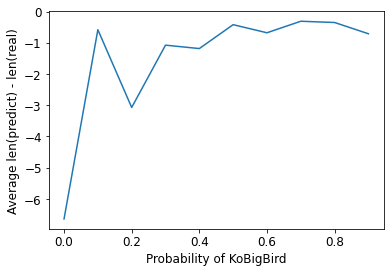

In [ ]:
x_label=[i*0.1 for i in range(10)]
plt.plot(x_label,list(np.mean(i) for i in edit_prob))
plt.rcParams.update({'font.size': 12})
plt.xlabel('Probability of KoBigBird')
plt.ylabel('Average len(predict) - len(real)')
plt.show()

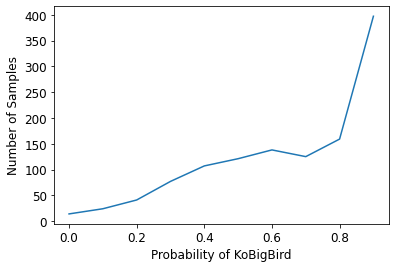

In [ ]:
x_label=[i*0.1 for i in range(10)]
plt.plot(x_label,list(len(i) for i in edit_prob))
plt.xlabel('Probability of KoBigBird')
plt.ylabel('Number of Samples')
plt.show()

평균: 2.539484621778886
표준편차: 4.602113295370871


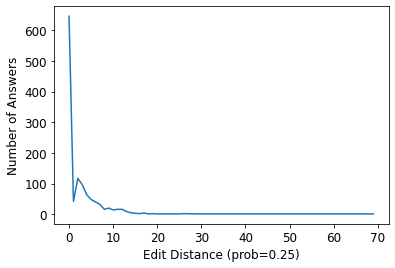

In [ ]:
anal_edit_dists(edit, print_log=False,text=f' (prob=0.25)')

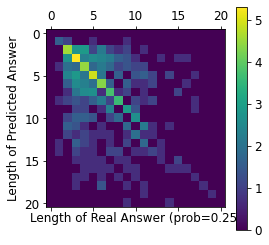

In [ ]:
heatmap(pred,real,do_log=True,text=f' (prob=0.25)')

In [ ]:
from collections import defaultdict
edit_counter = {i:defaultdict(int) for i in range(70)}
for i in range(len(pred)):
  if edit[i]>=70: continue
  edit_counter[edit[i]][len(real[i])-len(pred[i])]+=1

In [ ]:
#for i in edit_counter:
#  if i>30: break
#  print(f'{i}: {edit_counter[i]}')

In [ ]:
import math
edit_show = [[0]*17 for _ in range(21)]
for i in edit_counter:
  if i>20: break
  for j in edit_counter[i]:
      try: edit_show[i][8+int(8*(j/i if i else 0))]+=edit_counter[i][j]
      except: edit_show[i][16]+=edit_counter[i][j]
for i in edit_show:
  for j in range(len(i)):
    i[j] = math.log(i[j]+1)

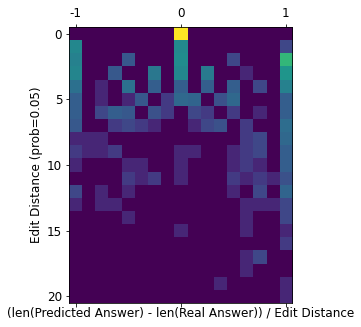

In [ ]:
import matplotlib.pyplot as plt

plt.matshow(edit_show)
plt.xlabel('(len(Predicted Answer) - len(Real Answer)) / Edit Distance')
plt.ylabel(f'Edit Distance (prob={prob_threshold})')
plt.xticks([0,8,16],labels=['-1','0','1'])
plt.show()

In [ ]:
def eval_edit(prob_threshold, max_len):
  edit_dists=[]
  for i in zip(pred,real,prob):
    ed = edit_distance(i[0],i[1]) if i[2]>prob_threshold else edit_distance(i[0][:max_len],i[1])
    edit_dists.append(ed)
  return np.mean(edit_dists), np.std(edit_dists)

In [ ]:
width=12
edit_len_prob = [[0]*width for _ in range(10)]; edit_len_prob_std = [[0]*width for _ in range(10)]
# answer len: 0 to 9
# prob threshold: 0.00 to 0.45
for local_prob in range(10):
  for local_len in range(width):
    m,s = eval_edit(local_prob*0.05, local_len)
    edit_len_prob[local_prob][local_len]=m
    edit_len_prob_std[local_prob][local_len]=s

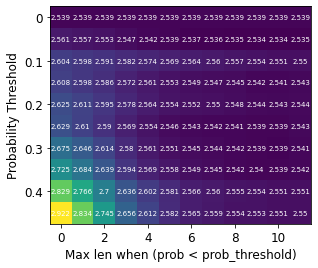

<Figure size 1080x1440 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt

fig,ax=plt.subplots()
ax.imshow(edit_len_prob)
plt.ylabel('Probability Threshold')
plt.xlabel(f'Max len when (prob < prob_threshold)')
plt.yticks([0,2,4,6,8],labels=[0,0.1,0.2,0.3,0.4])
plt.figure(figsize=(15,20))
#plt.rcParams.update({'font.size': 7})
for i in range(10):
  for j in range(width):
      ax.text(j,i,round(edit_len_prob[i][j],3), ha='center',va='center',color='w', fontsize=7)
plt.show()

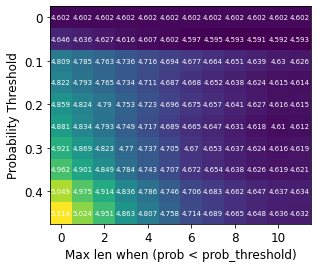

<Figure size 1080x1440 with 0 Axes>

In [ ]:
fig,ax=plt.subplots()
ax.imshow(edit_len_prob_std)
plt.ylabel('Probability Threshold')
plt.xlabel(f'Max len when (prob < prob_threshold)')
plt.yticks([0,2,4,6,8],labels=[0,0.1,0.2,0.3,0.4])
plt.figure(figsize=(15,20))
#plt.rcParams.update({'font.size': 7})
for i in range(10):
  for j in range(width):
      ax.text(j,i,round(edit_len_prob_std[i][j],3), ha='center',va='center',color='w', fontsize=7)
plt.show()

In [ ]:
'''count=0
for i in range(len(real)):
  #if len(pred[i])>=len(real[i])*2:
  #if len(real[i])>15:
  print(f'#{i}:',indexed_dev_dataset[i]['question'])
  print('Real:',real[i])
  print('Pred:',pred[i])
  print('Edit Distance:',edit[i])
  count+=1
  if count>20: break'''

"count=0\nfor i in range(len(real)):\n  #if len(pred[i])>=len(real[i])*2:\n  #if len(real[i])>15:\n  print(f'#{i}:',indexed_dev_dataset[i]['question'])\n  print('Real:',real[i])\n  print('Pred:',pred[i])\n  print('Edit Distance:',edit[i])\n  count+=1\n  if count>20: break"

# 실험

## Validation Data 실험 - 길이

In [ ]:
# 아무런 제한 없이
# get_pred_answer(dataset, prob_threshold=0.0, token_len_threshold=None)
pred_1, real, edit_1 = get_pred_answer(indexed_dev_dataset)

평균: 9.75561097256858
표준편차: 61.96369670016258


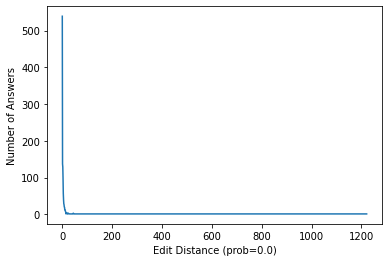

In [ ]:
anal_edit_dists(edit_1, print_log=False,text=f' (prob=0.0)')

1203 1203


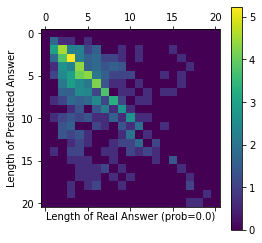

In [ ]:
print(len(pred_1),len(real))
heatmap(pred_1,real,do_log=True,text=f' (prob=0.0)')

Token MAX length = 1


  0%|          | 0/1203 [00:00<?, ?it/s]

평균: 35.38235294117647
표준편차: 56.1227723026425


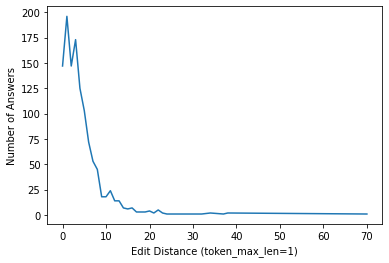

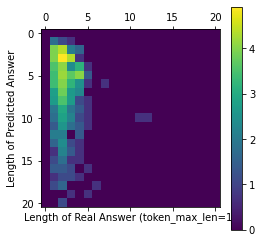

Token MAX length = 2


  0%|          | 0/1203 [00:00<?, ?it/s]

평균: 35.38235294117647
표준편차: 64.38533570066399


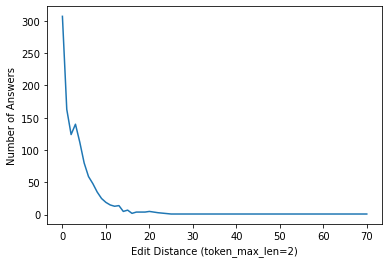

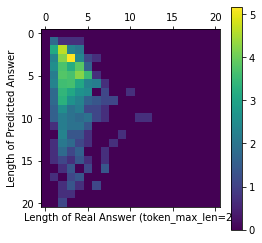

Token MAX length = 3


  0%|          | 0/1203 [00:00<?, ?it/s]

평균: 35.38235294117647
표준편차: 76.7938472971563


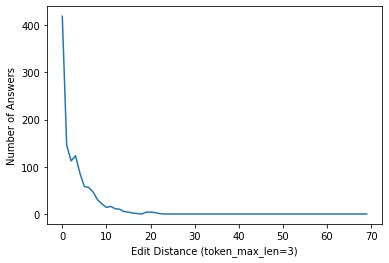

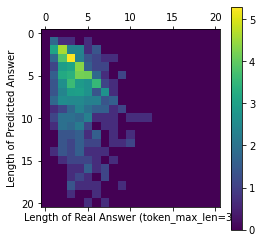

Token MAX length = 4


  0%|          | 0/1203 [00:00<?, ?it/s]

평균: 38.806451612903224
표준편차: 90.0037344583057


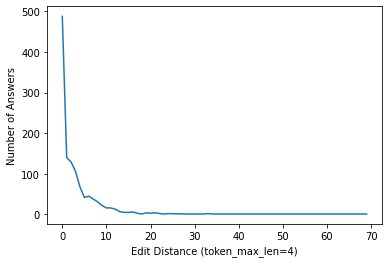

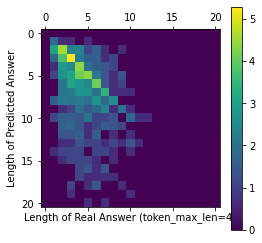

Token MAX length = 5


  0%|          | 0/1203 [00:00<?, ?it/s]

평균: 41.48275862068966
표준편차: 97.82271814611092


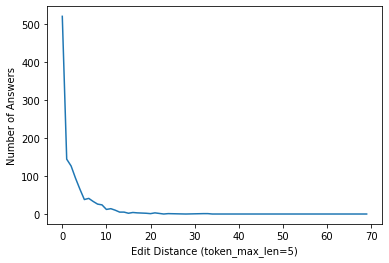

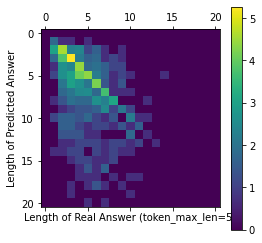

Token MAX length = 6


  0%|          | 0/1203 [00:00<?, ?it/s]

평균: 40.1
표준편차: 99.28690749539942


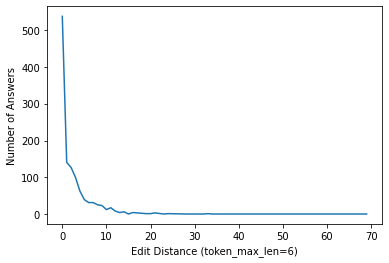

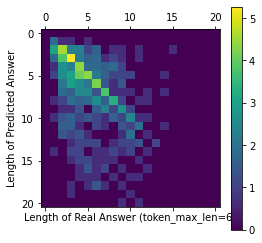

Token MAX length = 7


  0%|          | 0/1203 [00:00<?, ?it/s]

평균: 40.1
표준편차: 100.15699343197824


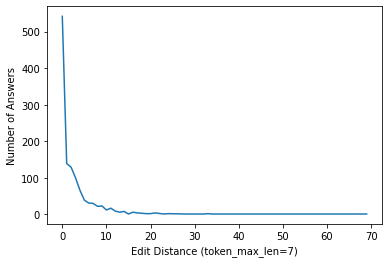

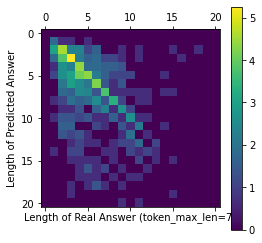

Token MAX length = 8


  0%|          | 0/1203 [00:00<?, ?it/s]

평균: 40.1
표준편차: 100.86471137122238


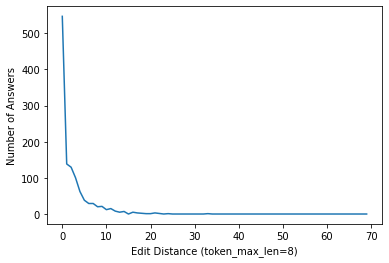

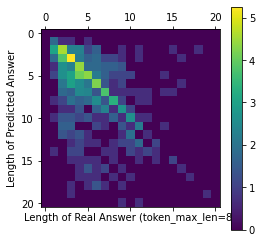

Token MAX length = 9


  0%|          | 0/1203 [00:00<?, ?it/s]

평균: 41.48275862068966
표준편차: 102.34950960570323


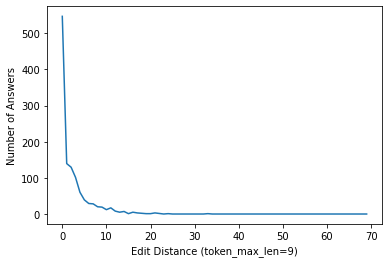

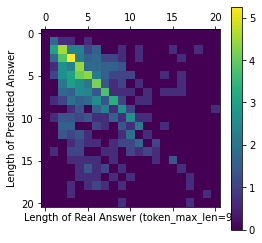

Token MAX length = 10


  0%|          | 0/1203 [00:00<?, ?it/s]

평균: 41.48275862068966
표준편차: 102.38757356230401


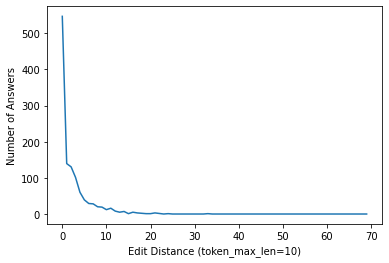

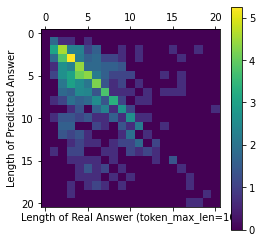

In [ ]:
'''pred=[[] for _ in range(11)];edit=[[] for _ in range(11)]
for l in range(1,11):
  print(f'Token MAX length = {l}')
  pred[l], _, edit[l] = get_pred_answer(indexed_dev_dataset, token_len_threshold=l)
  anal_edit_dists(edit[l], print_log=False,text=f' (token_max_len={l})')
  heatmap(pred[l],real,do_log=True,text=f' (token_max_len={l})')'''

Token MAX length = 11


  0%|          | 0/1203 [00:00<?, ?it/s]

평균: 2.6084788029925186
표준편차: 4.468658150497702


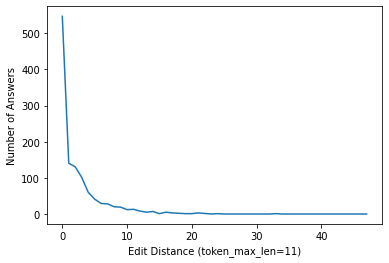

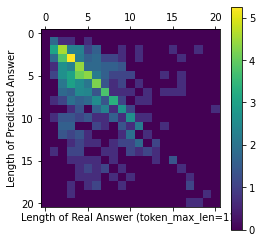

Token MAX length = 12


  0%|          | 0/1203 [00:00<?, ?it/s]

평균: 2.5868661679135494
표준편차: 4.438147232880598


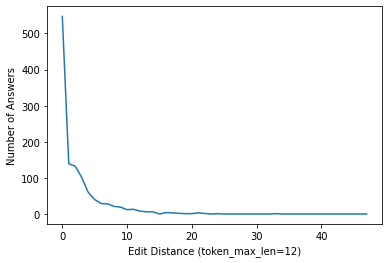

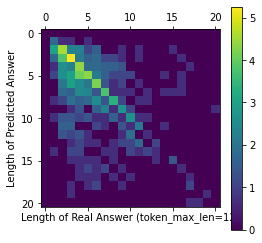

Token MAX length = 13


  0%|          | 0/1203 [00:00<?, ?it/s]

평균: 2.5868661679135494
표준편차: 4.438147232880598


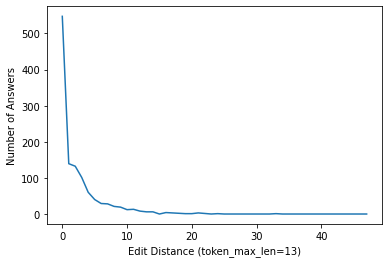

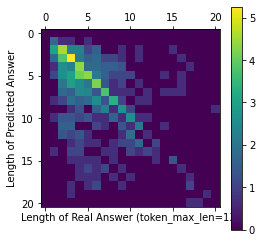

Token MAX length = 14


  0%|          | 0/1203 [00:00<?, ?it/s]

평균: 2.6442227763923523
표준편차: 4.5624627076484945


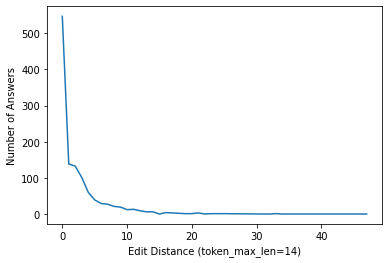

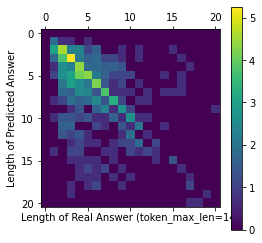

Token MAX length = 15


  0%|          | 0/1203 [00:00<?, ?it/s]

평균: 2.662510390689942
표준편차: 4.603748086188115


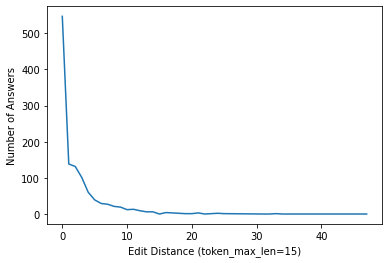

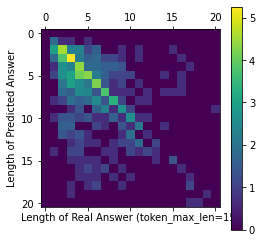

Token MAX length = 16


  0%|          | 0/1203 [00:00<?, ?it/s]

평균: 2.6475477971737322
표준편차: 4.559075633111422


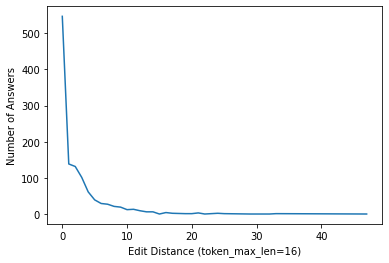

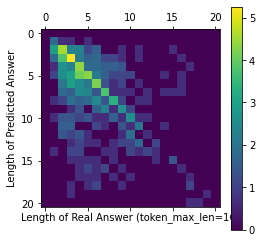

Token MAX length = 17


  0%|          | 0/1203 [00:00<?, ?it/s]

평균: 2.6142975893599334
표준편차: 4.4724179250131835


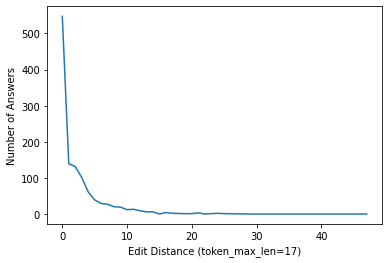

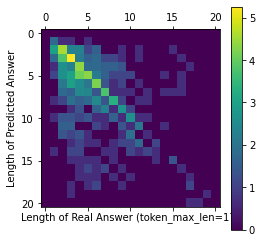

Token MAX length = 18


  0%|          | 0/1203 [00:00<?, ?it/s]

평균: 2.6442227763923523
표준편차: 4.5806459149067855


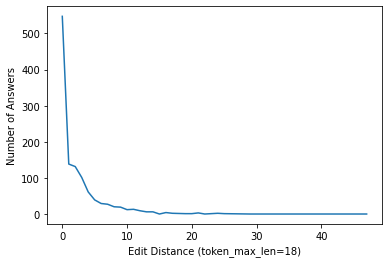

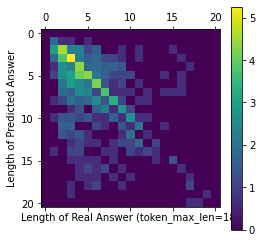

Token MAX length = 19


  0%|          | 0/1203 [00:00<?, ?it/s]

평균: 2.6442227763923523
표준편차: 4.5806459149067855


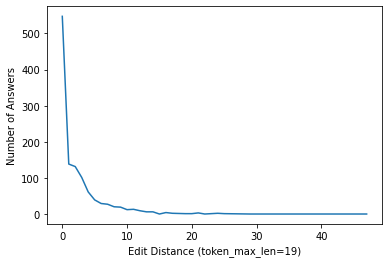

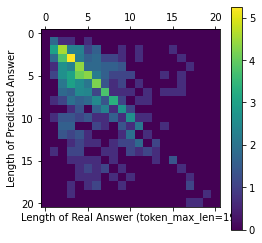

Token MAX length = 20


  0%|          | 0/1203 [00:00<?, ?it/s]

평균: 2.6475477971737322
표준편차: 4.60695923267967


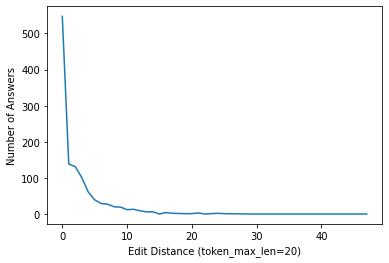

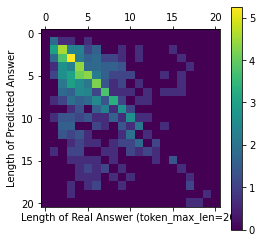

In [ ]:
pred+=[[] for _ in range(11)];edit+=[[] for _ in range(11)]
for l in range(11,21):
  print(f'Token MAX length = {l}')
  pred[l], _, edit[l] = get_pred_answer(indexed_dev_dataset, token_len_threshold=l)
  anal_edit_dists(edit[l], print_log=False,text=f' (token_max_len={l})')
  heatmap(pred[l],real,do_log=True,text=f' (token_max_len={l})')

Token MAX length = 1
평균: 4.403990024937656
표준편차: 5.1241981995816115


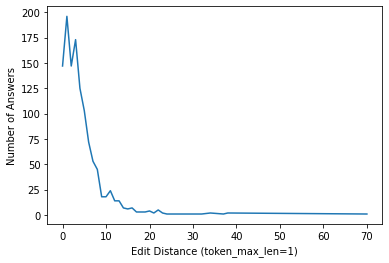

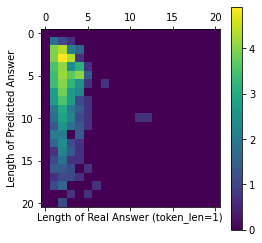

Token MAX length = 2
평균: 3.8462177888611806
표준편차: 5.151128348974982


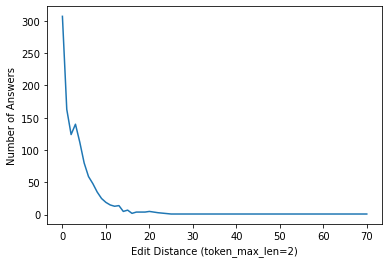

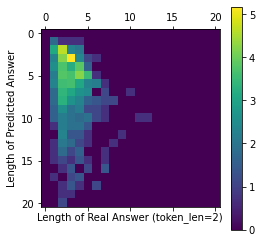

Token MAX length = 3
평균: 3.395677472984206
표준편차: 5.064805094220654


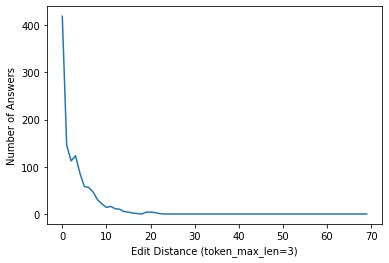

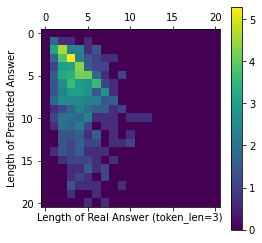

Token MAX length = 4
평균: 3.0407315045719034
표준편차: 4.944665055957545


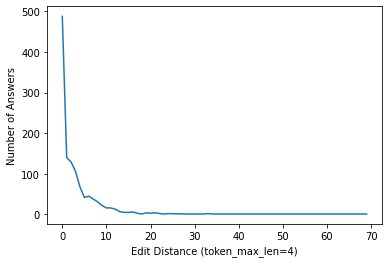

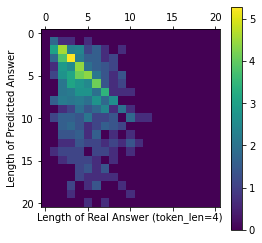

Token MAX length = 5
평균: 2.829592684954281
표준편차: 4.851756372757691


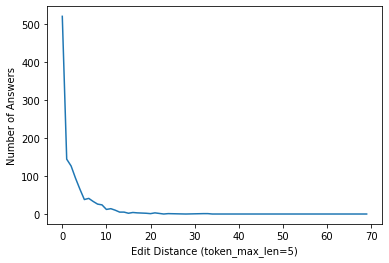

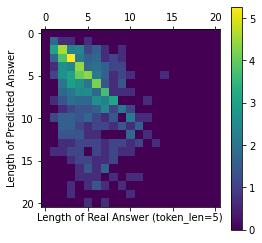

Token MAX length = 6
평균: 2.72402327514547
표준편차: 4.795604087049333


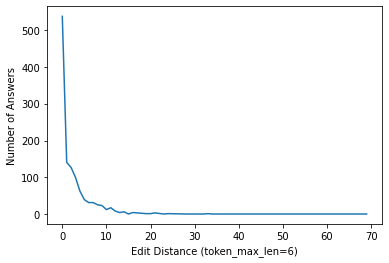

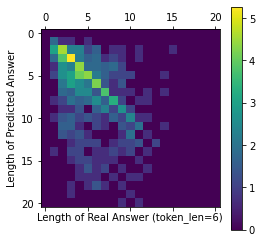

Token MAX length = 7
평균: 2.6990856192851207
표준편차: 4.806053002706305


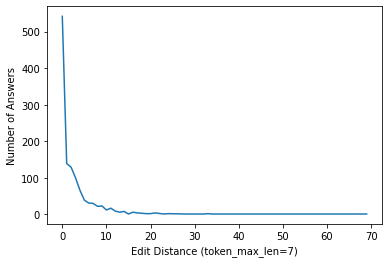

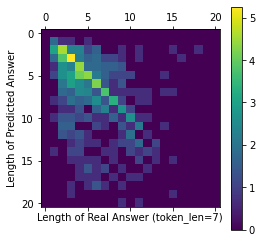

Token MAX length = 8
평균: 2.665835411471322
표준편차: 4.7569056277826745


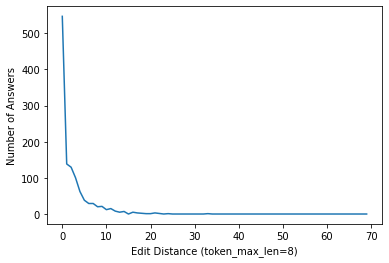

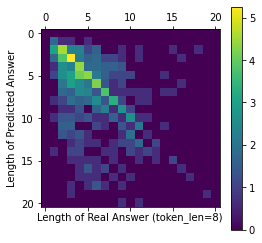

Token MAX length = 9
평균: 2.652535328345802
표준편차: 4.713289233738113


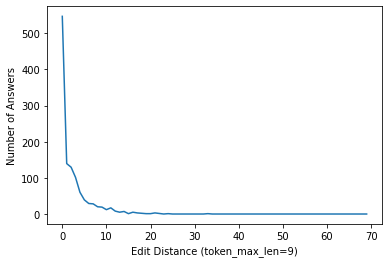

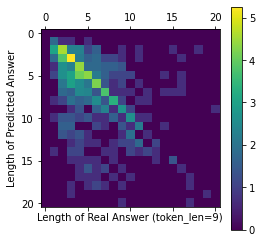

Token MAX length = 10
평균: 2.6450540315876974
표준편차: 4.707172333909232


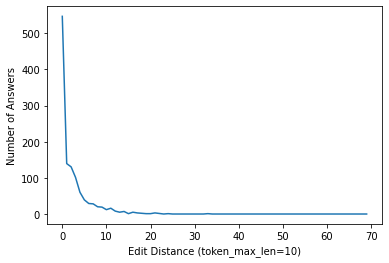

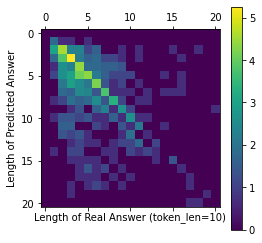

Token MAX length = 11
평균: 2.6084788029925186
표준편차: 4.468658150497702


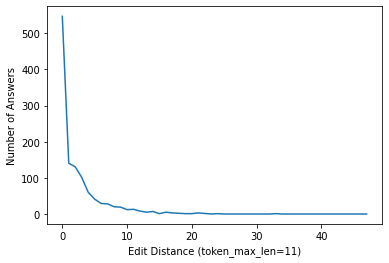

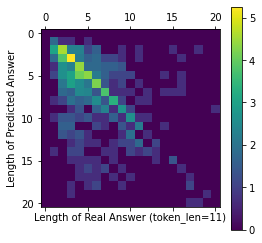

Token MAX length = 12
평균: 2.5868661679135494
표준편차: 4.438147232880598


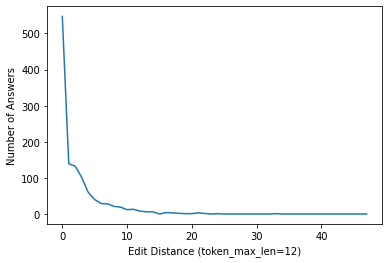

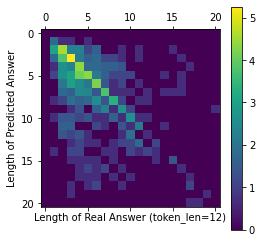

Token MAX length = 13
평균: 2.5868661679135494
표준편차: 4.438147232880598


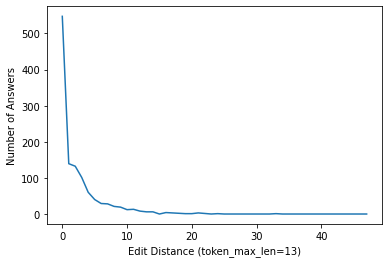

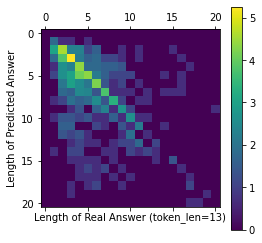

Token MAX length = 14
평균: 2.6442227763923523
표준편차: 4.5624627076484945


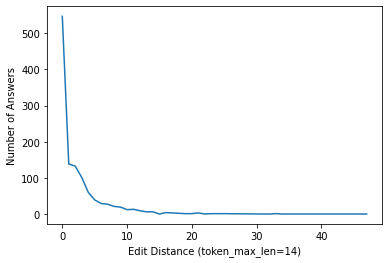

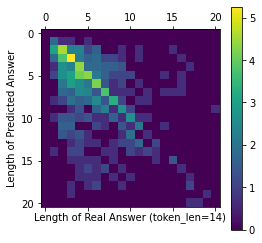

Token MAX length = 15
평균: 2.662510390689942
표준편차: 4.603748086188115


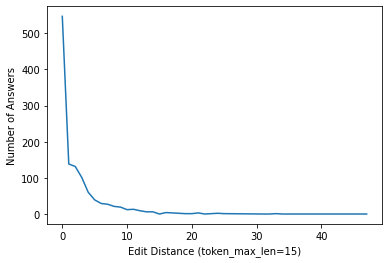

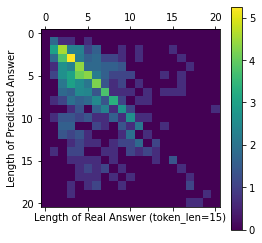

Token MAX length = 16
평균: 2.6475477971737322
표준편차: 4.559075633111422


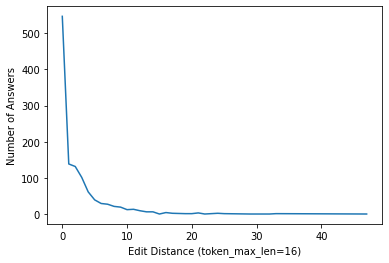

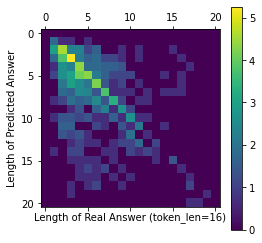

Token MAX length = 17
평균: 2.6142975893599334
표준편차: 4.4724179250131835


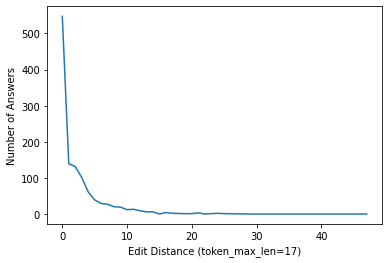

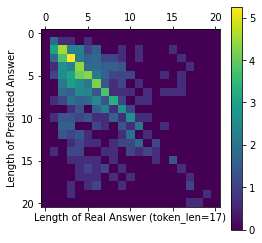

Token MAX length = 18
평균: 2.6442227763923523
표준편차: 4.5806459149067855


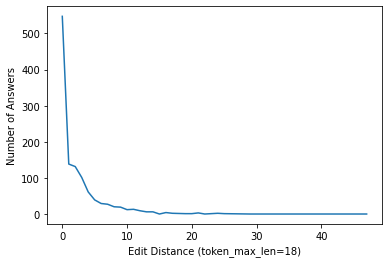

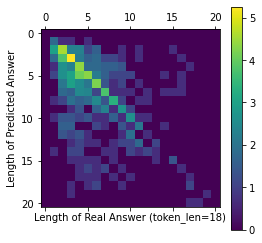

Token MAX length = 19
평균: 2.6442227763923523
표준편차: 4.5806459149067855


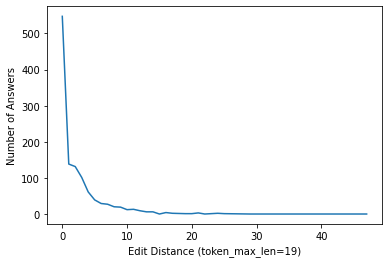

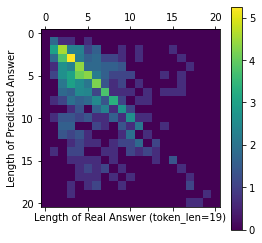

Token MAX length = 20
평균: 2.6475477971737322
표준편차: 4.60695923267967


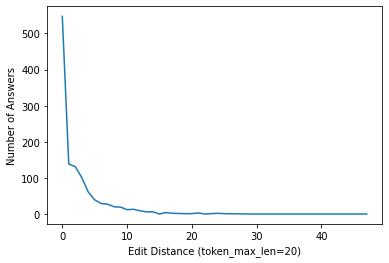

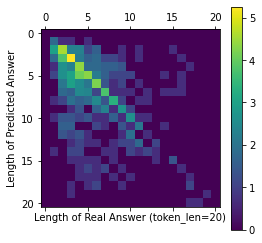

In [ ]:
token_len_log=[]
for l in range(1,21):
  #print(f'Probability = {prob*10}%')
  #anal_edit_dists(edit[prob], print_log=False,text=f' (prob={prob*0.1:.1f})')
  #heatmap(pred[prob],real,do_log=True,text=f' (prob={prob*0.1:.1f})')
  print(f'Token MAX length = {l}')
  anal_edit_dists(edit[l], print_log=False,text=f' (token_max_len={l})',write_log=token_len_log)
  heatmap(pred[l],real,do_log=True,text=f' (token_len={l})')

In [ ]:
token_len_log

[(4.403990024937656, 5.1241981995816115),
 (3.8462177888611806, 5.151128348974982),
 (3.395677472984206, 5.064805094220654),
 (3.0407315045719034, 4.944665055957545),
 (2.829592684954281, 4.851756372757691),
 (2.72402327514547, 4.795604087049333),
 (2.6990856192851207, 4.806053002706305),
 (2.665835411471322, 4.7569056277826745),
 (2.652535328345802, 4.713289233738113),
 (2.6450540315876974, 4.707172333909232),
 (2.6084788029925186, 4.468658150497702),
 (2.5868661679135494, 4.438147232880598),
 (2.5868661679135494, 4.438147232880598),
 (2.6442227763923523, 4.5624627076484945),
 (2.662510390689942, 4.603748086188115),
 (2.6475477971737322, 4.559075633111422),
 (2.6142975893599334, 4.4724179250131835),
 (2.6442227763923523, 4.5806459149067855),
 (2.6442227763923523, 4.5806459149067855),
 (2.6475477971737322, 4.60695923267967)]

## Validation 실험 - 확률

Probability = 10%


  0%|          | 0/1203 [00:00<?, ?it/s]

평균: 9.767248545303408
표준편차: 61.97994493429917


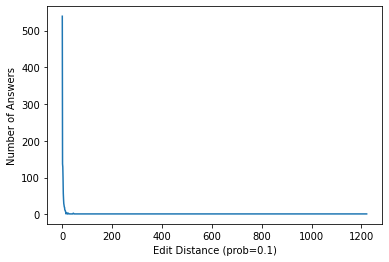

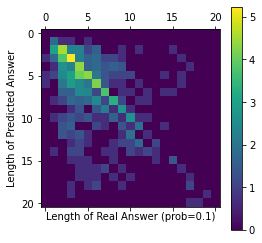

Probability = 20%


  0%|          | 0/1203 [00:00<?, ?it/s]

평균: 8.69243557772236
표준편차: 57.13829602046971


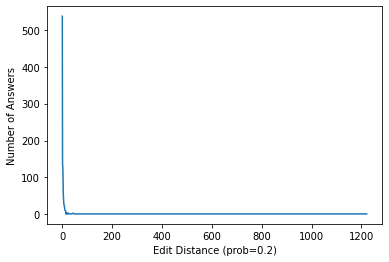

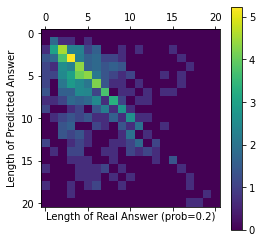

Probability = 30%


  0%|          | 0/1203 [00:00<?, ?it/s]

평균: 7.266001662510391
표준편차: 51.4902671759951


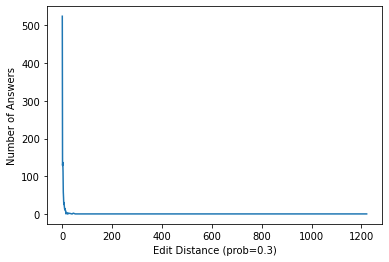

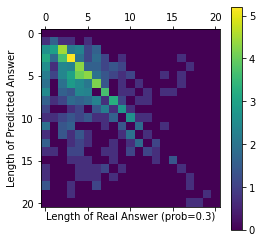

Probability = 40%


  0%|          | 0/1203 [00:00<?, ?it/s]

평균: 6.035743973399834
표준편차: 46.572688858087986


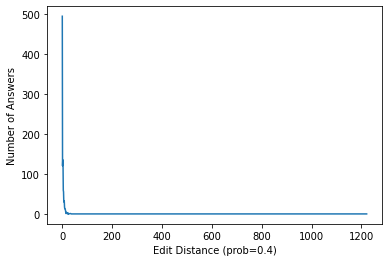

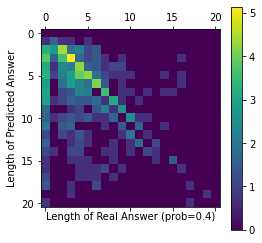

Probability = 50%


  0%|          | 0/1203 [00:00<?, ?it/s]

평균: 3.5527847049044055
표준편차: 7.424174649053569


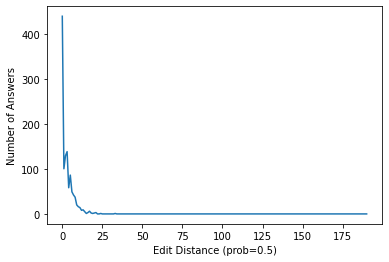

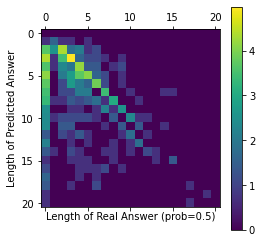

Probability = 60%


  0%|          | 0/1203 [00:00<?, ?it/s]

평균: 3.85286783042394
표준편차: 5.2774207791105745


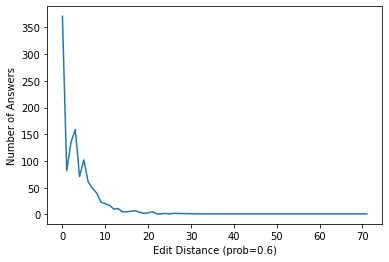

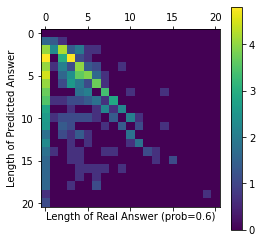

Probability = 70%


  0%|          | 0/1203 [00:00<?, ?it/s]

평균: 4.204488778054863
표준편차: 5.284247498125456


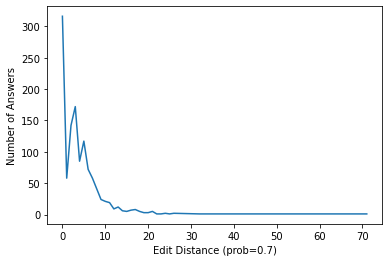

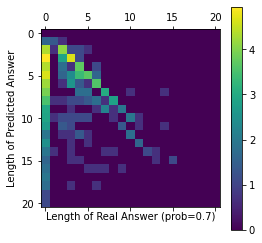

Probability = 80%


  0%|          | 0/1203 [00:00<?, ?it/s]

평균: 4.597672485453034
표준편차: 5.336964174755734


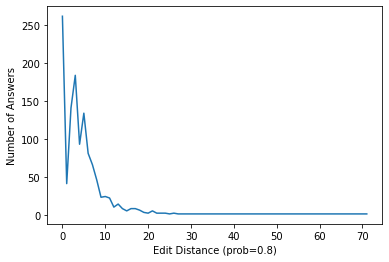

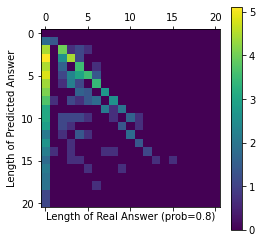

Probability = 90%


  0%|          | 0/1203 [00:00<?, ?it/s]

평균: 5.163757273482959
표준편차: 5.320074423157385


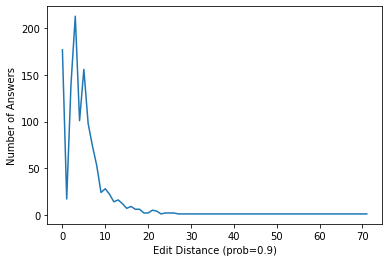

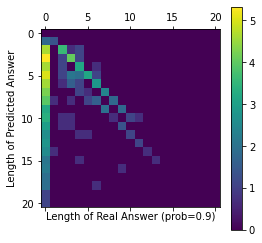

In [ ]:
'''pred_prob=[[] for _ in range(10)];edit_prob=[[] for _ in range(10)]
token_prob_log = []
for prob in range(1,10):
  print(f'Probability = {prob*10}%')
  pred_prob[prob], _, edit_prob[prob] = get_pred_answer(indexed_dev_dataset, prob_threshold=prob*0.1)
  anal_edit_dists(edit_prob[prob], print_log=False,text=f' (prob={prob*0.1:.1f})',write_log=token_prob_log)
  heatmap(pred_prob[prob],real,do_log=True,text=f' (prob={prob*0.1:.1f})')'''

In [ ]:
token_prob_log

[(9.767248545303408, 61.97994493429917),
 (8.69243557772236, 57.13829602046971),
 (7.266001662510391, 51.4902671759951),
 (6.035743973399834, 46.572688858087986),
 (3.5527847049044055, 7.424174649053569),
 (3.85286783042394, 5.2774207791105745),
 (4.204488778054863, 5.284247498125456),
 (4.597672485453034, 5.336964174755734),
 (5.163757273482959, 5.320074423157385)]

## Validation 실험 - 종합

In [ ]:
# 매 조건마다 학습을 다시 돌리는 건 비효율적이라 내부에서 구한 확률을 따로 빼버림
def get_pred_answer_eff(dataset):
  pred_answers = []
  for sample in tqdm(dataset):
      
      input_ids, token_type_ids = [
          torch.tensor(sample[key], dtype=torch.long, device="cuda")
          for key in ("input_ids", "token_type_ids")
      ]
      
      model.eval()
      with torch.no_grad():
          output = model(input_ids=input_ids[None, :], token_type_ids=token_type_ids[None, :])

      start_logits = output.start_logits
      end_logits = output.end_logits
      start_logits.squeeze_(0), end_logits.squeeze_(0)
      
      start_prob = start_logits[token_type_ids.bool()][1:-1].softmax(-1)
      end_prob = end_logits[token_type_ids.bool()][1:-1].softmax(-1)

      probability = torch.triu(start_prob[:, None] @ end_prob[None, :])

      pred_answers.append((start_prob, end_prob))
  return pred_answers

In [ ]:
token_len_idx_cache={}

In [ ]:
def get_pred(data_prob, dataset, prob_threshold=0.0, token_len_threshold=None):
  print(f'prob_threshold = {prob_threshold}, token_len_threshold = {token_len_threshold}')
  edit_dists = []
  #pred_answers = []
  #real_answers = []
  idx_cache = []
  
  for idx in tqdm(range(len(data_prob))):
      start_prob, end_prob = data_prob[idx]
      sample = dataset[idx]
      # 계산 시간 좀 줄일려고 일종의 DP를 씀
      if token_len_threshold in token_len_idx_cache: index = token_len_idx_cache[token_len_threshold][idx]
      else:
          probability = torch.triu(start_prob[:, None] @ end_prob[None, :])

          # 토큰 길이를 token_len_threshold까지만
          if token_len_threshold:
            for row in range(len(start_prob) - token_len_threshold):
                probability[row] = torch.cat((probability[row][:token_len_threshold+row].cpu(), torch.Tensor([0] * (len(start_prob)-(token_len_threshold+row))).cpu()), 0)

          index = torch.argmax(probability).item()
          idx_cache.append(index)
      
      start = index // len(end_prob)
      end = index % len(end_prob)

      # 확률이 prob_threshold 이하이면 자르기
      if start_prob[start] > prob_threshold and end_prob[end] > prob_threshold:
          start_str = sample['position'][start][0]
          end_str = sample['position'][end][1]
      else:
          start_str = 0
          end_str = 0

      pred_ans = sample['context'][start_str:end_str]

      edit_dists.append(edit_distance(pred_ans,sample['answers_text']))
      #pred_answers.append(pred_ans); real_answers.append(sample['answers_text'])
  if token_len_threshold not in token_len_idx_cache: token_len_idx_cache[token_len_threshold] = idx_cache
  return np.mean(edit_dists), np.std(edit_dists)

In [ ]:
#data_probs = get_pred_answer_eff(indexed_dev_dataset)

  0%|          | 0/1203 [00:00<?, ?it/s]

In [ ]:
#pred_tmp, real_tmp, edit_tmp = get_pred(data_probs, indexed_dev_dataset)

  0%|          | 0/1203 [00:00<?, ?it/s]

In [ ]:
complex_mean = [[0]*5 for _ in range(6)]
complex_std = [[0]*5 for _ in range(6)]
complex_mem = {}

In [ ]:
'''i=0
for leng in range(5,16,2):
  j=0
  for prob in range(0,10,2):
    mean,std = get_pred(data_probs, indexed_dev_dataset,prob_threshold=prob*0.1, token_len_threshold=leng)
    complex_mean[i][j] = mean
    complex_std[i][j] = std
    complex_mem[(leng,prob)] = (mean,std)
    j+=1
  i+=1'''

prob_threshold = 0.0, token_len_threshold = 5


  0%|          | 0/1203 [00:00<?, ?it/s]

prob_threshold = 0.2, token_len_threshold = 5


  0%|          | 0/1203 [00:00<?, ?it/s]

prob_threshold = 0.4, token_len_threshold = 5


  0%|          | 0/1203 [00:00<?, ?it/s]

prob_threshold = 0.6000000000000001, token_len_threshold = 5


  0%|          | 0/1203 [00:00<?, ?it/s]

prob_threshold = 0.8, token_len_threshold = 5


  0%|          | 0/1203 [00:00<?, ?it/s]

prob_threshold = 0.0, token_len_threshold = 7


  0%|          | 0/1203 [00:00<?, ?it/s]

prob_threshold = 0.2, token_len_threshold = 7


  0%|          | 0/1203 [00:00<?, ?it/s]

prob_threshold = 0.4, token_len_threshold = 7


  0%|          | 0/1203 [00:00<?, ?it/s]

prob_threshold = 0.6000000000000001, token_len_threshold = 7


  0%|          | 0/1203 [00:00<?, ?it/s]

prob_threshold = 0.8, token_len_threshold = 7


  0%|          | 0/1203 [00:00<?, ?it/s]

prob_threshold = 0.0, token_len_threshold = 9


  0%|          | 0/1203 [00:00<?, ?it/s]

prob_threshold = 0.2, token_len_threshold = 9


  0%|          | 0/1203 [00:00<?, ?it/s]

prob_threshold = 0.4, token_len_threshold = 9


  0%|          | 0/1203 [00:00<?, ?it/s]

prob_threshold = 0.6000000000000001, token_len_threshold = 9


  0%|          | 0/1203 [00:00<?, ?it/s]

prob_threshold = 0.8, token_len_threshold = 9


  0%|          | 0/1203 [00:00<?, ?it/s]

prob_threshold = 0.0, token_len_threshold = 11


  0%|          | 0/1203 [00:00<?, ?it/s]

prob_threshold = 0.2, token_len_threshold = 11


  0%|          | 0/1203 [00:00<?, ?it/s]

prob_threshold = 0.4, token_len_threshold = 11


  0%|          | 0/1203 [00:00<?, ?it/s]

prob_threshold = 0.6000000000000001, token_len_threshold = 11


  0%|          | 0/1203 [00:00<?, ?it/s]

prob_threshold = 0.8, token_len_threshold = 11


  0%|          | 0/1203 [00:00<?, ?it/s]

prob_threshold = 0.0, token_len_threshold = 13


  0%|          | 0/1203 [00:00<?, ?it/s]

prob_threshold = 0.2, token_len_threshold = 13


  0%|          | 0/1203 [00:00<?, ?it/s]

prob_threshold = 0.4, token_len_threshold = 13


  0%|          | 0/1203 [00:00<?, ?it/s]

prob_threshold = 0.6000000000000001, token_len_threshold = 13


  0%|          | 0/1203 [00:00<?, ?it/s]

prob_threshold = 0.8, token_len_threshold = 13


  0%|          | 0/1203 [00:00<?, ?it/s]

prob_threshold = 0.0, token_len_threshold = 15


  0%|          | 0/1203 [00:00<?, ?it/s]

IndexError: ignored

In [ ]:
i=5
complex_mean.append([0]*5)
complex_std.append([0]*5)
j=0
for prob in range(0,10,2):
  mean,std = get_pred(data_probs, indexed_dev_dataset,prob_threshold=prob*0.1, token_len_threshold=15)
  complex_mean[i][j] = mean
  complex_std[i][j] = std
  complex_mem[(leng,prob)] = (mean,std)
  j+=1

prob_threshold = 0.0, token_len_threshold = 15


  0%|          | 0/1203 [00:00<?, ?it/s]

prob_threshold = 0.2, token_len_threshold = 15


  0%|          | 0/1203 [00:00<?, ?it/s]

prob_threshold = 0.4, token_len_threshold = 15


  0%|          | 0/1203 [00:00<?, ?it/s]

prob_threshold = 0.6000000000000001, token_len_threshold = 15


  0%|          | 0/1203 [00:00<?, ?it/s]

prob_threshold = 0.8, token_len_threshold = 15


  0%|          | 0/1203 [00:00<?, ?it/s]

In [ ]:
for i in complex_mean:
  for j in i:
    print(j, end='\t')
  print()

2.829592684954281	3.1288445552784703	3.508728179551122	4.137988362427265	4.770573566084788	
2.6990856192851207	2.7747298420615127	3.1487946799667497	3.9318370739817126	4.6259351620947635	
2.652535328345802	2.70573566084788	3.0931005818786366	3.8753117206982544	4.597672485453034	
2.6084788029925186	2.6674979218620116	3.0623441396508726	3.8753117206982544	4.597672485453034	
2.5868661679135494	2.650872817955112	3.0224438902743143	3.85286783042394	4.597672485453034	
2.662510390689942	2.7265170407315047	3.0232751454696594	3.85286783042394	4.597672485453034	


In [ ]:
for i in complex_std:
  for j in i:
    print(j, end='\t')
  print()

4.851756372757691	5.267493839569418	5.488646057050862	5.493977200489534	5.432016039914473	
4.806053002706305	4.9922593271675435	5.259228974231534	5.382340095577474	5.364027749884569	
4.713289233738113	4.881286506484483	5.196678133189963	5.326676286806457	5.336964174755734	
4.468658150497702	4.826757573045108	5.1662569909330145	5.326676286806457	5.336964174755734	
4.438147232880599	4.775889030279469	5.086320056436764	5.2774207791105745	5.336964174755734	
4.603748086188115	4.929176213456864	5.087705283391105	5.2774207791105745	5.336964174755734	


In [ ]:
complex_mem

{(5, 0): (2.829592684954281, 4.851756372757691),
 (5, 2): (3.1288445552784703, 5.267493839569418),
 (5, 4): (3.508728179551122, 5.488646057050862),
 (5, 6): (4.137988362427265, 5.493977200489534),
 (5, 8): (4.770573566084788, 5.432016039914473),
 (7, 0): (2.6990856192851207, 4.806053002706305),
 (7, 2): (2.7747298420615127, 4.9922593271675435),
 (7, 4): (3.1487946799667497, 5.259228974231534),
 (7, 6): (3.9318370739817126, 5.382340095577474),
 (7, 8): (4.6259351620947635, 5.364027749884569),
 (9, 0): (2.652535328345802, 4.713289233738113),
 (9, 2): (2.70573566084788, 4.881286506484483),
 (9, 4): (3.0931005818786366, 5.196678133189963),
 (9, 6): (3.8753117206982544, 5.326676286806457),
 (9, 8): (4.597672485453034, 5.336964174755734),
 (11, 0): (2.6084788029925186, 4.468658150497702),
 (11, 2): (2.6674979218620116, 4.826757573045108),
 (11, 4): (3.0623441396508726, 5.1662569909330145),
 (11, 6): (3.8753117206982544, 5.326676286806457),
 (11, 8): (4.597672485453034, 5.336964174755734),
 (

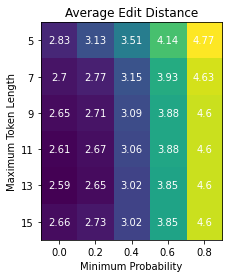

In [ ]:
fig, ax = plt.subplots()
ax.imshow(complex_mean)

plt.xlabel('Minimum Probability')
plt.ylabel('Maximum Token Length')
ax.set_title("Average Edit Distance")
for i in range(6):
  for j in range(5):
    text = ax.text(j,i,round(complex_mean[i][j],2),ha='center',va='center',color='w')
#plt.xlim([5,16])
#plt.ylim([0,1])
ax.set_xticks(np.arange(5))
ax.set_xticklabels([0.0,0.2,0.4,0.6,0.8])
ax.set_yticks(np.arange(6))
ax.set_yticklabels([5,7,9,11,13,15])
plt.show()

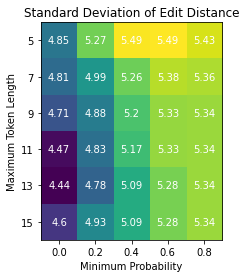

In [ ]:
fig, ax = plt.subplots()
ax.imshow(complex_std)

plt.xlabel('Minimum Probability')
plt.ylabel('Maximum Token Length')
ax.set_title("Standard Deviation of Edit Distance")
for i in range(6):
  for j in range(5):
    text = ax.text(j,i,round(complex_std[i][j],2),ha='center',va='center',color='w')
#plt.xlim([5,16])
#plt.ylim([0,1])
ax.set_xticks(np.arange(5))
ax.set_xticklabels([0.0,0.2,0.4,0.6,0.8])
ax.set_yticks(np.arange(6))
ax.set_yticklabels([5,7,9,11,13,15])
plt.show()